# Определение возраста покупателей

## Исследовательский анализ данных

### Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

**Для решения поставленной задачи будем придерживатья следующих шагов:**

 - Проведём исследовательский анализ набора фотографий.
 - Подготовим данные к обучению
 - Обучим нейронную ресть и рассчитаем её качество

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Велечины
RANDOM_STATE=123
BATCH_SIZE=12

In [2]:
# Загрузка данных
data = pd.read_csv('/datasets/faces/labels.csv')

Далее создадим итератор и загрузим фото с числом вораста человека

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        seed=RANDOM_STATE)

Found 7591 validated image filenames.


Проведем анализ датасета

In [5]:
print(data.info())
print('Размер датасета:', data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
Размер датасета: (7591, 2)


In [6]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


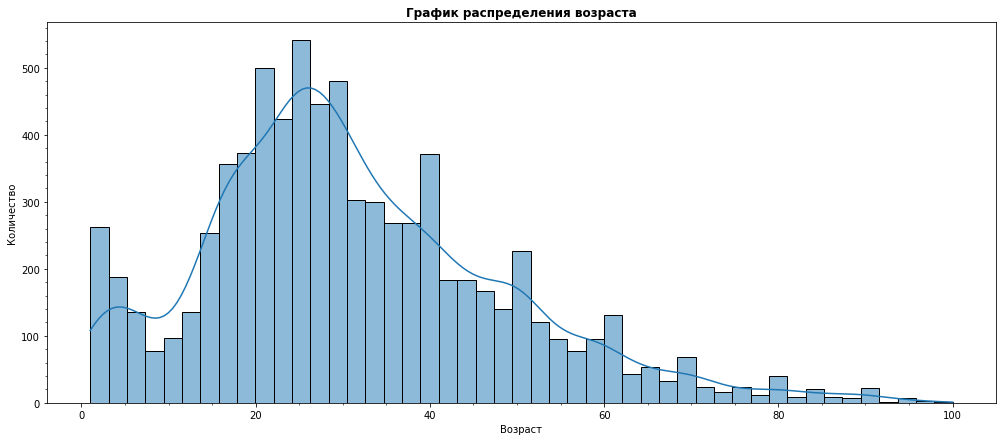

In [7]:
# Построение графика распределения возраста
plt.figure(figsize=(17,7))
sns.histplot(data=data,
             x='real_age',
             kde=True)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('График распределения возраста', fontweight='bold')
plt.xticks(rotation=0)
plt.minorticks_on()

**Вывод:**
Мы загрузили необходимые данные и провели легкий анализ:
- Размер датасета насчитывает 7591 фотографию
- Средний возраст составляет 31 год
- Максимальный и минимальный возраст соответственно 100 лет  и 1 год.
- Смещение графика влево показывает на маленькое количество людей больших возрастов, что может сказаться на дизбалансе классов

### Выборка фотографий

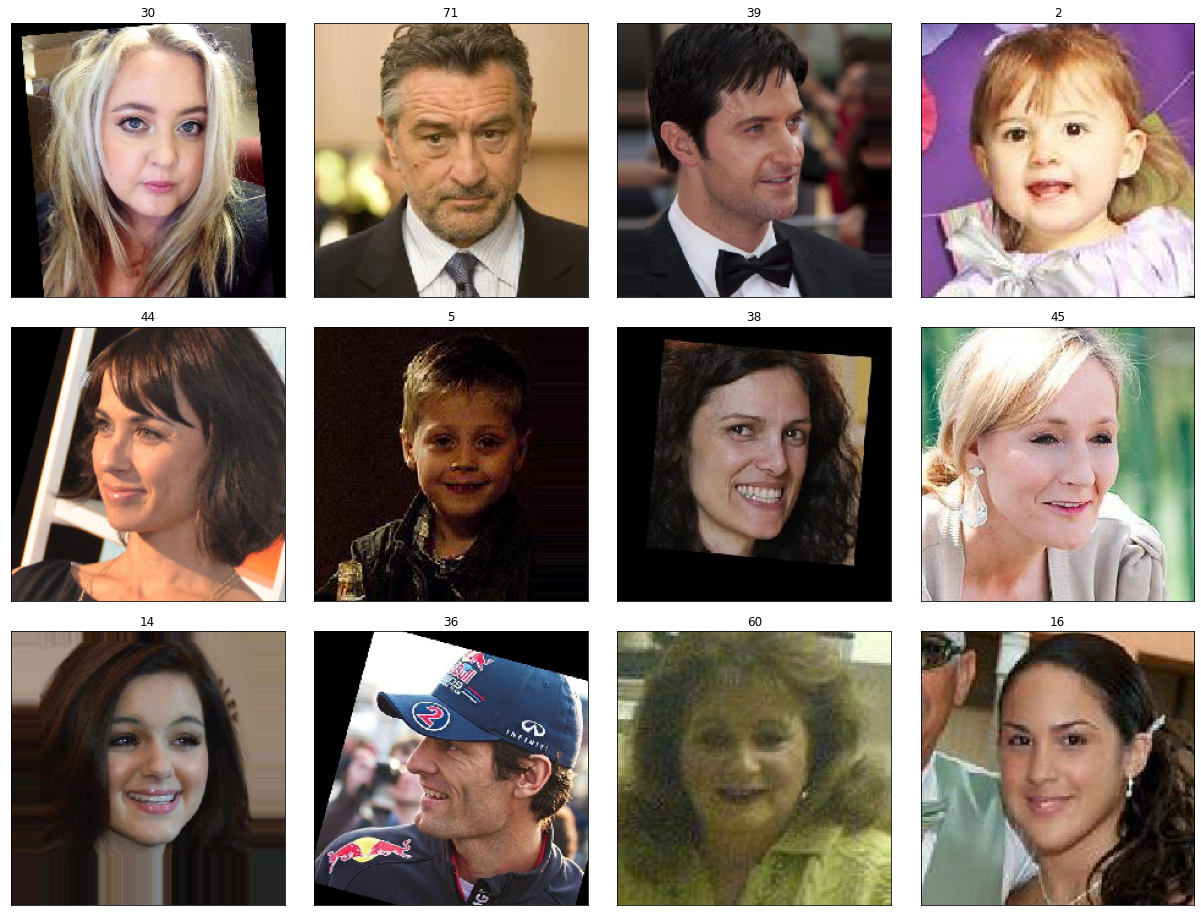

In [9]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(17, 17))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout();

**Вывод:**
- Все фотографии разные практически по всем параметрам:: качество, размер объекта, освещение, посторонние предметы и тд
- По фото заметно, что состав людей по возрасту сильно отличается.
- Присутствуют повороты изображения для выравнивания лица.
- Сильно отличаются эмоции людей на данных фотографиях 


Мы определили некоторые особенности имеющихся в нашем распоряжении фотографий. Будем стараться учитывать эти особенности при подготовки модели машинного обучения, используя аугментацию данных. Она полжна помочь модели научиться обобщать и распознавать лица в различных условиях, что должно приводить к улучшению показателей метрики нашей модели.

## Обучение модели

### Код модели обучения на GPU

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

random_state = 123
BATCH_SIZE = 32

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='training',
        seed=random_state)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='validation',
        seed=random_state)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

### Результат кода 

```

Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-09-07 00:26:23.051285: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-07 00:26:24.113492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 64s - loss: 268.0327 - mae: 11.6848 - val_loss: 938.9608 - val_mae: 25.8308
Epoch 2/20
178/178 - 38s - loss: 83.1527 - mae: 6.8514 - val_loss: 556.3463 - val_mae: 18.1222
Epoch 3/20
178/178 - 38s - loss: 53.3041 - mae: 5.5321 - val_loss: 294.1526 - val_mae: 12.7582
Epoch 4/20
178/178 - 38s - loss: 38.4602 - mae: 4.7283 - val_loss: 128.1427 - val_mae: 8.6010
Epoch 5/20
178/178 - 38s - loss: 28.1976 - mae: 4.0376 - val_loss: 76.0392 - val_mae: 6.5181
Epoch 6/20
178/178 - 38s - loss: 23.3645 - mae: 3.7238 - val_loss: 82.7629 - val_mae: 6.7712
Epoch 7/20
178/178 - 38s - loss: 18.3982 - mae: 3.2806 - val_loss: 69.2983 - val_mae: 6.2301
Epoch 8/20
178/178 - 38s - loss: 14.4917 - mae: 2.8988 - val_loss: 67.2909 - val_mae: 6.0295
Epoch 9/20
178/178 - 38s - loss: 11.1871 - mae: 2.5625 - val_loss: 63.2739 - val_mae: 5.9828
Epoch 10/20
178/178 - 38s - loss: 9.3465 - mae: 2.3226 - val_loss: 64.0986 - val_mae: 6.0349
Epoch 11/20
178/178 - 38s - loss: 8.7817 - mae: 2.2528 - val_loss: 71.2839 - val_mae: 6.3155
Epoch 12/20
178/178 - 38s - loss: 8.3888 - mae: 2.1982 - val_loss: 62.3322 - val_mae: 5.9138
Epoch 13/20
178/178 - 38s - loss: 7.8358 - mae: 2.1280 - val_loss: 67.6861 - val_mae: 6.1874
Epoch 14/20
178/178 - 38s - loss: 7.3040 - mae: 2.0543 - val_loss: 64.9429 - val_mae: 5.9497
Epoch 15/20
178/178 - 38s - loss: 7.6056 - mae: 2.0969 - val_loss: 76.2900 - val_mae: 6.7519
Epoch 16/20
178/178 - 38s - loss: 8.0058 - mae: 2.1263 - val_loss: 74.0977 - val_mae: 6.4959
Epoch 17/20
178/178 - 38s - loss: 7.4029 - mae: 2.0633 - val_loss: 62.9454 - val_mae: 6.0004
Epoch 18/20
178/178 - 38s - loss: 6.7522 - mae: 1.9862 - val_loss: 60.8095 - val_mae: 5.7628
Epoch 19/20
178/178 - 38s - loss: 6.9297 - mae: 2.0010 - val_loss: 66.9253 - val_mae: 6.1827
Epoch 20/20
178/178 - 38s - loss: 7.1811 - mae: 2.0213 - val_loss: 64.6307 - val_mae: 6.0519
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 64.6307 - mae: 6.0519
Test MAE: 6.0519

```

## Анализ обученной модели

Наша задача получить на итоговой модели значение метрики МАЕ не выше 7, показатель нашей модели составил 6.05. Поэтому можно считать, что данную модель можно использовать на реальных задачах. 

Данная метрика показывает, что наша модель может определить возрастную группу покупателя супермаркета с точностью +- 6 лет. Такая точность может быть использована супермаркетом «Хлеб-Соль» для улучшения взаимодействия с клиентами, для анализа покупок с целью предложений товары, которые могут заинтересовать покупателей разной возрастной группы.

В качестве дальнейшей рекомендации предлагаем заказчику собрать свой банк с фотографиями посетителей и дообучить модель на фотографиях, сделанных непосредственно на территории супермаркета. Это позволит улучшить точность предсказаний алгоритма в будущем.